In [1]:
import gym
from baselines import deepq
from baselines import bench
from baselines import logger
from baselines.common.atari_wrappers import make_atari
from baselines.common.atari_wrappers import LazyFrames

# Add noice v1

execution:  0.013010978698730469 seconds


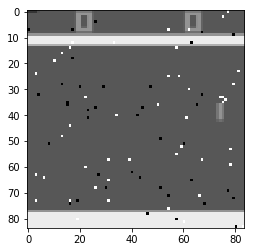

In [11]:
import datetime
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import time

%matplotlib inline

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output
    
# image = cv2.imread('pong.jpg')
# for i in range(1000000):
#     noise_img = sp_noise(image, 0.005)
#     if i%1000 == 0:
#         print(i, datetime.datetime.now().time())

    
image = cv2.imread('messigray.png')

start = time.time()
noise_img = sp_noise(image, 0.005)
end = time.time()
print('execution: ', end - start, 'seconds')

cv2.imwrite('sp_noise.jpg', noise_img)
#plt.imshow(image[:,:,::-1])
#plt.show()

plt.imshow(noise_img[:,:,::-1])
plt.show()

(84, 84)


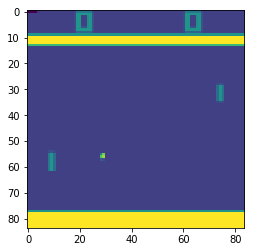

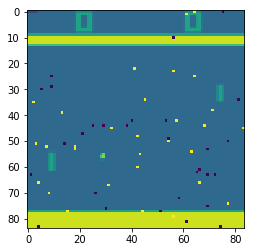

In [27]:
def show_random_env():
    env = make_atari('PongNoFrameskip-v4')
    env = deepq.wrap_atari_dqn(env)

    obs = env.reset()
    for i in range(15):
        obs, rew, done, _ = env.step(1)
    img = np.array(obs[None])[:,:,1].reshape((84,84))
    print(img.shape)
    plt.imshow(img)
    cv2.imwrite('messigray.png',img)
    plt.show()

    obs_noice = sp_noise(img, 0.005)
    plt.imshow(obs_noice)
    plt.show()
    
show_random_env()

# Add noice v2

In [4]:
from PIL import Image
import numpy as np
import time

def add_noise(image, paper_threshold, salt_threshold):
    w, h = image.shape
    random_paper = np.random.rand(w, h)
    random_salt = np.random.rand(w, h)
    image[random_paper < paper_threshold] = 0
    image[random_salt < salt_threshold] = 255
    return image

def add_noise_frames(lazy_frames, paper_threshold, salt_threshold):
    images = []
    for image in lazy_frames._frames:
        output = add_noise(image.reshape((84, 84)), paper_threshold, salt_threshold)
        images.append(output.reshape((84, 84, 1)))
    
    return LazyFrames(list(images))

def add_noise_t(image, paper_threshold, salt_threshold):
    w, h = image.size
    pixels = np.array(image)
    random_paper = np.random.rand(w, h)
    random_salt = np.random.rand(w, h)
    pixels[random_paper < paper_threshold] = 0
    pixels[random_salt < salt_threshold] = 255
    return Image.fromarray(pixels)

def test_add_noise():
    n = 10000
    avg_agg = 0
    median_agg = []
    image = Image.open("messigray.png")
    for i in range(n):
        start = time.time()
        noisy = add_noise_t(image, 0.01, 0.01)
        duration = time.time() - start
        avg_agg += duration
        median_agg.append(duration)
    noisy.save("out.png")
    avg = avg_agg / n
    median_agg.sort()
    print("number or runs", n)
    print("average duration:", avg, "seconds")
    print("median duration: ", median_agg[n // 2], "seconds")
    
    # test performance for reshaping
    env = make_atari('PongNoFrameskip-v4')
    env = deepq.wrap_atari_dqn(env)
    obs = env.reset()
    
    start = time.time()

    a = obs._frames[0]
    a.reshape((84, 84))
    a.reshape((84, 84,1))

    end = time.time()
    print('test reshaping, execution: ', end - start, 'seconds')
    
test_add_noise()

number or runs 10000
average duration: 0.00032285914421081543 seconds
median duration:  0.00023698806762695312 seconds
test reshaping, execution:  5.9604644775390625e-06 seconds


# Train and Test

In [9]:
import tensorflow as tf
from baselines.common.tf_util import get_session

def clean_session_fix():
    get_session().close()
    tf.reset_default_graph() 

In [12]:
def play_pong():
    logger.configure()
    env = make_atari('PongNoFrameskip-v4')
    env = bench.Monitor(env, logger.get_dir())
    env = deepq.wrap_atari_dqn(env)

    model = deepq.learn(
        env,
        "conv_only",
        convs=[(32, 8, 4), (64, 4, 2), (64, 3, 1)],
        hiddens=[256],
        dueling=True,
        total_timesteps=0,
        load_path="models/pong_model_r.pkl"  
    )

    while True:
        obs, done = env.reset(), False
        episode_rew = 0
        while not done:
            env.render()
            #start = time.time()
            obs_noice = add_noise_frames(obs, 0.005, 0.005)
            # end = time.time()
            # print('test reshaping, execution: ', end - start, 'seconds')
            
            obs, rew, done, _ = env.step(model(obs_noice[None])[0])
            episode_rew += rew
        print("Episode reward", episode_rew)

def test_play_pong(use_noice=False, model_name='models/pong_model_d.pkl', 
                   number_of_runs = 10, show_render = False):
    env = make_atari('PongNoFrameskip-v4')
    env = deepq.wrap_atari_dqn(env)

    model = deepq.learn(
        env,
        "conv_only",
        convs=[(32, 8, 4), (64, 4, 2), (64, 3, 1)],
        hiddens=[256],
        dueling=True,
        total_timesteps=0,
        load_path=model_name  
    )

    rewards = []
    for i in range(number_of_runs):
        obs, done = env.reset(), False
        episode_rew = 0
        while not done:
            if show_render:
                env.render()
            
            #start = time.time()
            obs_updated = obs
            if use_noice:
                obs_updated = add_noise_frames(obs, 0.005, 0.005)
            # end = time.time()
            # print('test reshaping, execution: ', end - start, 'seconds')
            
            obs, rew, done, _ = env.step(model(obs_updated[None])[0])
            episode_rew += rew
        rewards.append(episode_rew)
        # print(datetime.datetime.now().time(), i, episode_rew)
        
    return np.mean(rewards)

In [10]:
clean_session_fix()
avg_reward = test_play_pong(False, "models/pong_model_d.pkl")
print('DD', avg_reward)

clean_session_fix()
avg_reward = test_play_pong(True, "models/pong_model_d.pkl")
print('DR', avg_reward)

clean_session_fix()
avg_reward = test_play_pong(False, "models/pong_model_r.pkl")
print('RD', avg_reward)

clean_session_fix()
avg_reward = test_play_pong(True, "models/pong_model_r.pkl")
print('RR', avg_reward)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
Logging to /var/folders/bk/wyc4h4vd6cvd247fghhsptbc0000gn/T/openai-2019-05-05-13-47-01-247527
Loaded model from models/pong_model_d.pkl
DD 18.5
Loaded model from models/pong_model_d.pkl
DR -20.3
Loaded model from models/pong_model_r.pkl
RD 18.1
Loaded model from models/pong_model_r.pkl
RR 17.7


In [33]:
clean_session_fix() 
test_play_pong(True, "models/pong_model_d.pkl", 1, True)

Loaded model from models/pong_model_d.pkl


-20.0